In [48]:
import numpy as np
import pandas as pd

raw_df = pd.read_csv("./Housing.csv")
raw_df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [49]:
raw_df.shape

(545, 13)

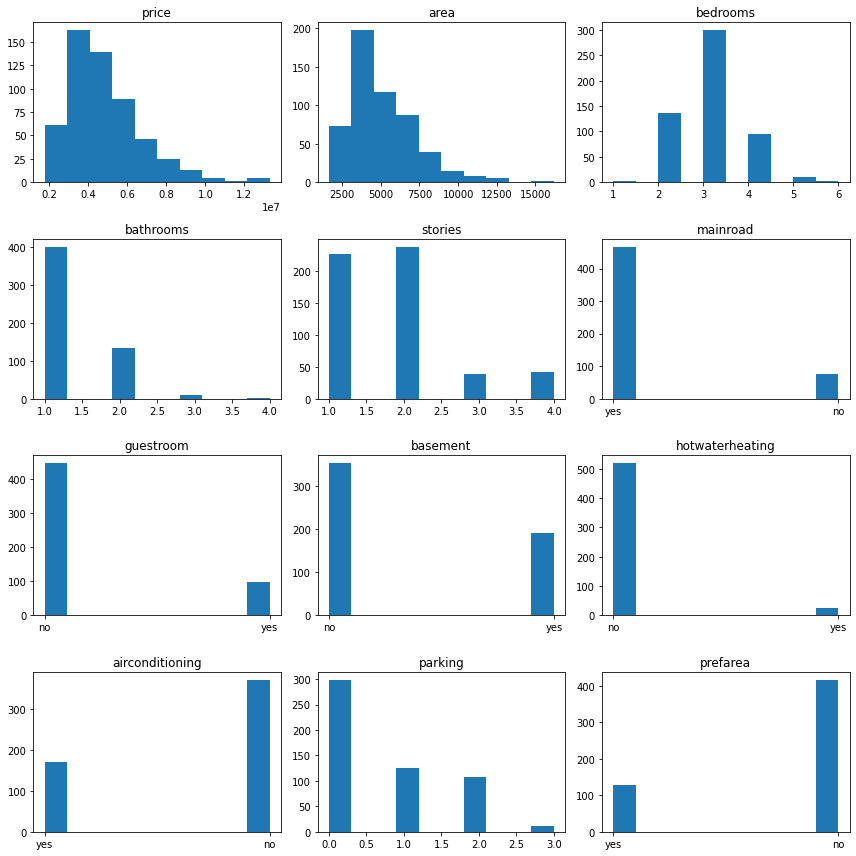

In [50]:
import matplotlib.pyplot as plt

def plot_columns(df: pd.DataFrame):
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 12))
    for i in range(4):
        for j in range(3):
            axes[i, j].hist(raw_df[raw_df.columns[(i*3) + j]])
            axes[i, j].set_title(raw_df.columns[(i*3) + j])

    plt.tight_layout()
    
plot_columns(raw_df)

In [51]:
raw_df.isna().sum()

price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64

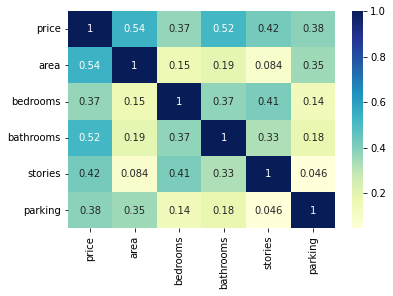

In [52]:
import seaborn as sb

sb.heatmap(raw_df.corr(), cmap="YlGnBu", annot=True)
plt.show()

In [53]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


In [54]:
df = raw_df.copy()

bool_cols = ["mainroad", "guestroom", "basement", "hotwaterheating", "airconditioning", "prefarea"]
df[bool_cols] = df[bool_cols].replace({"no": 0, "yes": 1})

In [55]:
np.unique(df["furnishingstatus"])

array(['furnished', 'semi-furnished', 'unfurnished'], dtype=object)

In [56]:
df["furnishingstatus"] = df["furnishingstatus"].replace({"unfurnished": 0, "semi-furnished": 1, "furnished": 2})

In [57]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.model_selection import train_test_split

def train_rf(df: pd.DataFrame):
    df = df.copy()
    X = df.drop('price', axis=1)
    y = df['price']

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    train_predictions = rf.predict(X_train)
    train_score = mean_squared_log_error(y_train, train_predictions)
    print("Train MSLE:", train_score)

    val_predictions = rf.predict(X_val)
    val_score = mean_squared_log_error(y_val, val_predictions)
    print("Validation MSLE:", val_score)
    
    return rf

rf = train_rf(df)

Train MSLE: 0.0072267493301602466
Validation MSLE: 0.07150989923811035


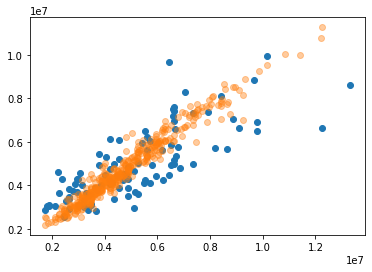

In [58]:
df = df.copy()
X = df.drop('price', axis=1)
y = df['price']
    
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

train_predictions = rf.predict(X_train)
train_score = mean_squared_log_error(y_train, train_predictions)

val_predictions = rf.predict(X_val)
val_score = mean_squared_log_error(y_val, val_predictions)

plt.scatter(y_val, val_predictions)
plt.scatter(y_train, train_predictions, alpha=0.4)
plt.show()

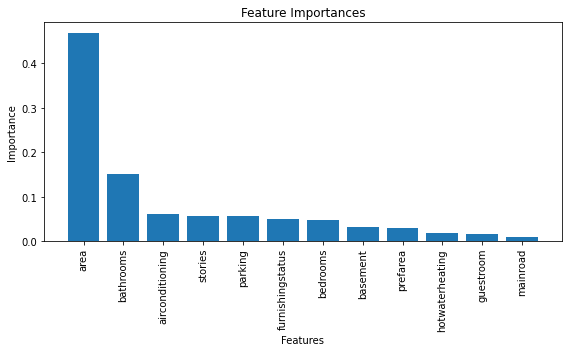

In [59]:
importances = rf.feature_importances_

feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 5))
plt.bar(feature_importances['Feature'], feature_importances['Importance'])
plt.xticks(rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.tight_layout()
plt.show()

In [60]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'max_depth': [None, 5, 10],  # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
}

rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# Perform grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=2)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Parameters:", best_params)

best_model = grid_search.best_estimator_
val_predictions = best_model.predict(X_val)
val_score = mean_squared_log_error(y_val, val_predictions)
print("Validation MSLE:", val_score)

Best Parameters: {'max_depth': 10, 'min_samples_split': 10}
Validation MSLE: 0.07443212308412483


In [61]:
rf = RandomForestRegressor(n_estimators=100, random_state=42, 
                           n_jobs=-1, max_depth=10, min_samples_split=10)
rf.fit(X_train, y_train)

val_predictions = rf.predict(X_val)
val_score = mean_squared_log_error(y_val, val_predictions)
print("Validation MSLE:", val_score)

Validation MSLE: 0.07443212308412488


In [62]:
base_df = df.copy()

3430000.0 5740000.0


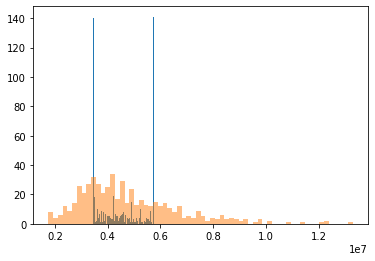

Train MSLE: 0.0020803563504605714
Validation MSLE: 0.019378753875053327


In [71]:
df = base_df.copy()
q1 = np.percentile(df["price"], 25)
q3 = np.percentile(df["price"], 75)
print(q1, q3)
df["price"] = np.clip(df["price"], a_min=q1, a_max=q3)
plt.hist(df["price"], bins=64)
plt.hist(raw_df["price"], alpha=0.5, bins=64)
plt.show()

_ = train_rf(df)

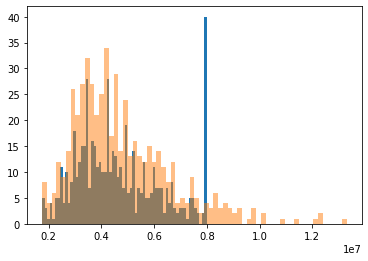

Train MSLE: 0.0065285795797577015
Validation MSLE: 0.061842358769792716


In [73]:
df = base_df.copy()

df["price"] = np.clip(df["price"], a_min=np.min(df["price"]), a_max=0.8 * 1e7)
plt.hist(df["price"], bins=64)
plt.hist(raw_df["price"], alpha=0.5, bins=64)
plt.show()

_ = train_rf(df)

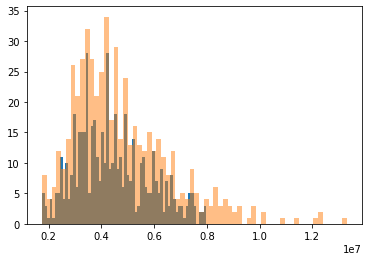

Train MSLE: 0.006619728697766237
Validation MSLE: 0.0534797586490143


In [75]:
df = base_df.copy()

df = df.drop(df[df["price"] > 0.8 * 1e7].index)
plt.hist(df["price"], bins=64)
plt.hist(raw_df["price"], alpha=0.5, bins=64)
plt.show()

_ = train_rf(df)

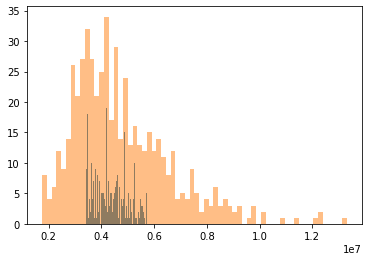

Train MSLE: 0.0021182310639873106
Validation MSLE: 0.017373427348824518


In [77]:
df = base_df.copy()

df = df.drop(df[(df["price"] > q3) | (df["price"] < q1)].index)
plt.hist(df["price"], bins=64)
plt.hist(raw_df["price"], alpha=0.5, bins=64)
plt.show()

_ = train_rf(df)

In [78]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor

def train_lr(df: pd.DataFrame):
    df = df.copy()
    X = df.drop('price', axis=1)
    y = df['price']

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    lr = LinearRegression()
    lr.fit(X_train, y_train)

    train_predictions = lr.predict(X_train)
    train_score = mean_squared_log_error(y_train, train_predictions)
    print("Train MSLE:", train_score)

    val_predictions = lr.predict(X_val)
    val_score = mean_squared_log_error(y_val, val_predictions)
    print("Validation MSLE:", val_score)
    

def train_svr(df: pd.DataFrame):
    df = df.copy()
    X = df.drop('price', axis=1)
    y = df['price']

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    s = SVR()
    s.fit(X_train, y_train)

    train_predictions = s.predict(X_train)
    train_score = mean_squared_log_error(y_train, train_predictions)
    print("Train MSLE:", train_score)

    val_predictions = s.predict(X_val)
    val_score = mean_squared_log_error(y_val, val_predictions)
    print("Validation MSLE:", val_score)

def train_nb(df: pd.DataFrame):
    df = df.copy()
    X = df.drop('price', axis=1)
    y = df['price']

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    nbr = GaussianNB()
    nbr.fit(X_train, y_train)

    train_predictions = nbr.predict(X_train)
    train_score = mean_squared_log_error(y_train, train_predictions)
    print("Train MSLE:", train_score)

    val_predictions = nbr.predict(X_val)
    val_score = mean_squared_log_error(y_val, val_predictions)
    print("Validation MSLE:", val_score)
    
def train_knn(df: pd.DataFrame):
    df = df.copy()
    X = df.drop('price', axis=1)
    y = df['price']

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    knn = KNeighborsRegressor()
    knn.fit(X_train, y_train)

    train_predictions = knn.predict(X_train)
    train_score = mean_squared_log_error(y_train, train_predictions)
    print("Train MSLE:", train_score)

    val_predictions = knn.predict(X_val)
    val_score = mean_squared_log_error(y_val, val_predictions)
    print("Validation MSLE:", val_score)
    

print("lr")
train_lr(df)
print("rf")
train_rf(df)
print("svr")
train_svr(df)
print("nb")
train_nb(df)
print("knn")
train_knn(df)

lr
Train MSLE: 0.012369149713188053
Validation MSLE: 0.018366264065293656
rf
Train MSLE: 0.0021182310639873106
Validation MSLE: 0.017373427348824518
svr
Train MSLE: 0.02119336527351941
Validation MSLE: 0.023545542786958536
nb
Train MSLE: 0.014133295685389407
Validation MSLE: 0.03387984292567202
knn
Train MSLE: 0.01439601799143969
Validation MSLE: 0.01705575444978012


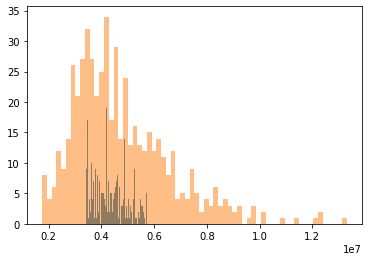

Train MSLE: 0.0021796714122192615
Validation MSLE: 0.01561972506024839


In [81]:
df = base_df.copy()

df = df.drop(df[(df["price"] > q3) | (df["price"] < q1) | (df["area"] > 10_000)].index)
plt.hist(df["price"], bins=64)
plt.hist(raw_df["price"], alpha=0.5, bins=64)
plt.show()

rf = train_rf(df)

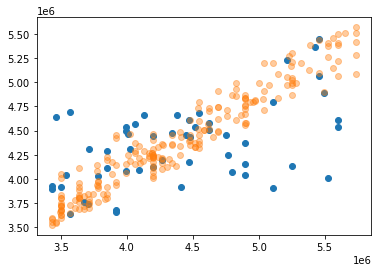

In [80]:
X = df.drop('price', axis=1)
y = df['price']
    
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

train_predictions = rf.predict(X_train)
train_score = mean_squared_log_error(y_train, train_predictions)

val_predictions = rf.predict(X_val)
val_score = mean_squared_log_error(y_val, val_predictions)

plt.scatter(y_val, val_predictions)
plt.scatter(y_train, train_predictions, alpha=0.4)
plt.show()